In [1]:
import numpy as np
from jax import numpy as jnp, jit
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.constants import m_p

from shone.opacity import Opacity, generate_synthetic_opacity
from shone.transmission import novais_2024

2024-07-31 16:49:27,380 - WARNING - File .dacerc not found. You are requesting data in public mode. To change this behaviour, create a .dacerc file in your home directory and fill it with your API key. More infos on https://dace.unige.ch


In [2]:
wavelength = np.linspace(0.8, 1.7, 100)  # [µm]
wavenumber = 1e4 / wavelength  # [cm]
pressure = 10 ** np.array([-6, -5.66, -5.33, -5, -4.66, -4.33, -4, -3.66, -3.33, -3, -2.66,
                           -2.33, -2, -1.66, -1.33, -1, -0.66, -0.33, 0, 0.33, 0.66, 1.0])  # [bar]
temperature = np.r_[200:700:50, 700:1500:100, 1500:3100:200] # [K]

In [3]:
#from shone.opacity.dace import download_molecule

#download_molecule(
#    molecule_name='H2O',
#    temperature_range=[200, 3100],
#    pressure_range=[-6, 1]
#)

In [4]:
#generate_synthetic_opacity(temperature, pressure, wavelength, filename='w' + str(len(wavelength)) + '_example_' +
#                           str(temperature[0]) + '_' + str(temperature[-1]) + '_' + 
#                           str(np.log10(pressure[0])) + '_' + str(np.log10(pressure[-1])) + '_1.nc')  # T0_Tfinal_logP0_logPfinal_version.nc

generate_synthetic_opacity(temperature, pressure, wavelength, filename='1H2-16O_POKAZATEL_' +
                           str(temperature[0]) + '_' + str(temperature[-1]) + '_' + 
                           str(np.log10(pressure[0])) + '_' + str(np.log10(pressure[-1])) + '_2.nc')  # T0_Tfinal_logP0_logPfinal_version.nc

In [5]:
Opacity.get_available_species()

name,species,charge,line_list,version,size_gb,path,index
str9,str9,int64,str9,int64,float64,str65,int64
H2O,1H2-16O,--,POKAZATEL,2,10.013,/Users/astroaline/.shone/1H2-16O_POKAZATEL_200_3100_-6_1_2.nc,0
H2O,1H2-16O,--,POKAZATEL,2,0.067,/Users/astroaline/.shone/1H2-16O_POKAZATEL_2500_2500_-6_-6_2.nc,1
H2O,1H2-16O,--,POKAZATEL,2,0.0,/Users/astroaline/.shone/1H2-16O_POKAZATEL_200_2900_-6.0_1.0_2.nc,2
Na,Na,0,VALD,1,0.096,/Users/astroaline/.shone/Na_0_VALD_2500_2500_-8.0_-8.0_1.nc,3
synthetic,synthetic,--,example,0,0.0,/Users/astroaline/.shone/synthetic_example_0_0_0_0_0.nc,4
w10,w10,--,example,1,0.0,/Users/astroaline/.shone/w10_example_200_3000_-6.0_1.0_1.nc,5


In [6]:
# Some numbers needed
mmm = 18 * m_p
n_levels = 200

# Make pressure ranges in levels
pressure_levels_log = jnp.linspace(jnp.log10(pressure[0]), jnp.log10(pressure[-1]), n_levels)
pressure_levels = 10 ** pressure_levels_log

In [7]:
# load the synthetic opacity file:
#opacity = Opacity.load_species_from_name('w' + str(len(wavelength)))

opacity = Opacity.load_species_from_index(2)

#crop = ((0.8 < opacity.grid.wavelength) & (opacity.grid.wavelength < 1.7))
#opacity.grid = opacity.grid.isel(wavelength=crop)

print(opacity.grid.coords)

# get a jitted 3D interpolator over wavelength, temperature, pressure:
tau_interpolator_grid, optical_depth = opacity.get_interpolator_noniso(n_levels, mmm)

Coordinates:
  * wavelength   (wavelength) float64 800B 0.8 0.8091 0.8182 ... 1.682 1.691 1.7
  * temperature  (temperature) int32 104B 200 250 300 350 ... 2500 2700 2900
  * pressure     (pressure) float64 176B 1e-06 2.188e-06 ... 4.571 10.0


In [8]:
def closest(lst, K):
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i] - K))]

# Indexes for plotting
my_t, my_p, my_w = 1000, 1e-2, 1.1
t = list(temperature).index(my_t)
p = list(pressure_levels).index(closest(pressure_levels, my_p))
w = list(wavelength).index(my_w)

tau_temperature, tau_pressure, tau_wavelength = [], [], []

for i in range(len(temperature)):
    tau_temperature.append(optical_depth[i][p][w])

for j in range(len(pressure_levels)):
    tau_pressure.append(optical_depth[t][j][w])

for k in range(len(wavelength)):
    tau_wavelength.append(optical_depth[t][p][k])

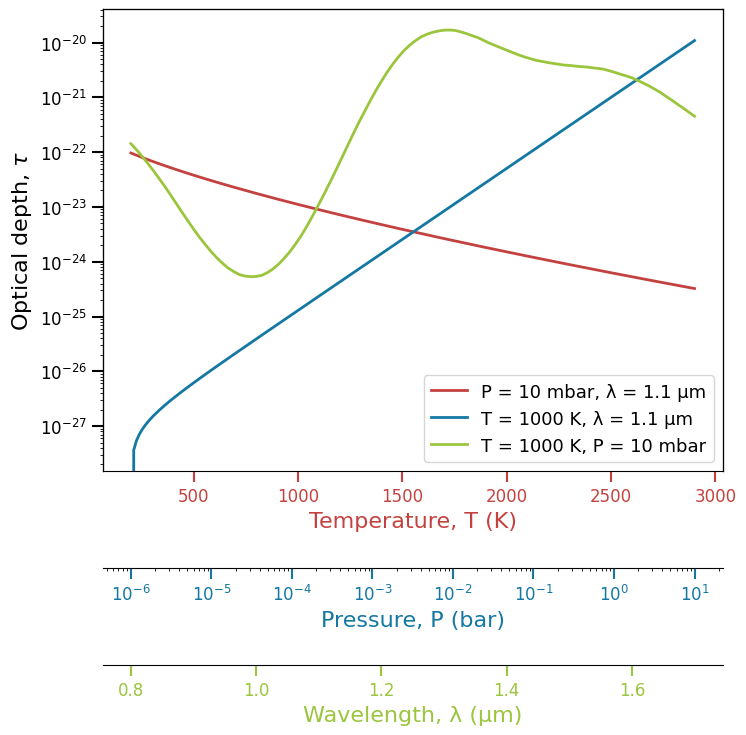

In [9]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

twin1 = ax.twiny()
twin2 = ax.twiny()

twin1.xaxis.set_ticks_position('bottom')
twin1.xaxis.set_label_position('bottom')
twin2.xaxis.set_ticks_position('bottom')
twin2.xaxis.set_label_position('bottom')

ax.spines['bottom'].set_position(('outward', 0))
twin1.spines['bottom'].set_position(('outward', 70))
twin2.spines['bottom'].set_position(('outward', 140))

plot1, = ax.semilogy(temperature, tau_temperature, color='#C3423F', lw=2)
plot2, = twin1.loglog(pressure_levels, tau_pressure, color='#1478A3', lw=2)
plot3, = twin2.semilogy(wavelength, tau_wavelength, color='#9BC53D', lw=2)

str1 = 'P = ' + str(int(my_p * 1e3)) + ' mbar, λ = ' + str(my_w) + ' µm'
str2 = 'T = ' + str(my_t) + ' K, λ = ' + str(my_w) + ' µm'
str3 = 'T = ' + str(my_t) + ' K, P = ' + str(int(my_p * 1e3)) + ' mbar'

ax.legend([plot1, plot2, plot3], [str1, str2, str3],
          loc='lower right', fontsize=13)

ax.set_ylabel(r'Optical depth, $\tau$', size=16)
ax.set_xlabel('Temperature, T (K)', size=16)
twin1.set_xlabel('Pressure, P (bar)', size=16)
twin2.set_xlabel('Wavelength, λ (µm)', size=16)

ax.xaxis.label.set_color(plot1.get_color())
twin1.xaxis.label.set_color(plot2.get_color())
twin2.xaxis.label.set_color(plot3.get_color())

tkw = dict(size=8, width=1.5, labelsize=12)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', colors=plot1.get_color(), **tkw)
twin1.tick_params(axis='x', colors=plot2.get_color(), **tkw)
twin2.tick_params(axis='x', colors=plot3.get_color(), **tkw)

plt.show()

In [10]:
P_cloudtop = 1e-1 # [bar]

optical_depth_cloud = np.zeros((len(pressure_levels), len(wavelength)))
optical_depth_cloud[pressure_levels > P_cloudtop,:] = np.inf

for i in pressure_levels:
    if i < P_cloudtop:
        cloudtop_index = list(pressure_levels).index(i) + 1

tau_cloud_wavelength = []
for k in range(len(wavelength)):
    tau_cloud_wavelength.append(optical_depth_cloud[p][k])

In [11]:
# interpolate for a range of wavelengths at one pressure and temperature:
temperature = np.array([200, 600, 1000])  # [K]
pressure = np.array([1e-3, 1e-1, 1e1])  # [bar]

def closest(lst, K):
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i] - K))]

# Indexes for plotting
t0, t1, t2 = list(temperature).index(temperature[0]), list(temperature).index(temperature[1]), list(temperature).index(temperature[2])
p0, p1, p2 = list(pressure_levels).index(closest(pressure_levels, pressure[0])), list(pressure_levels).index(closest(pressure_levels, pressure[1])), list(pressure_levels).index(closest(pressure_levels, pressure[2]))

tau_00_wavelength, tau_01_wavelength, tau_02_wavelength = [], [], []
tau_10_wavelength, tau_11_wavelength, tau_12_wavelength = [], [], []
tau_20_wavelength, tau_21_wavelength, tau_22_wavelength = [], [], []

for k in range(len(wavelength)):
    tau_00_wavelength.append(optical_depth[t0][p0][k])
    tau_01_wavelength.append(optical_depth[t0][p1][k])
    tau_02_wavelength.append(optical_depth[t0][p2][k])

    tau_10_wavelength.append(optical_depth[t1][p0][k])
    tau_11_wavelength.append(optical_depth[t1][p1][k])
    tau_12_wavelength.append(optical_depth[t1][p2][k])

    tau_20_wavelength.append(optical_depth[t2][p0][k])
    tau_21_wavelength.append(optical_depth[t2][p1][k])
    tau_22_wavelength.append(optical_depth[t2][p2][k])

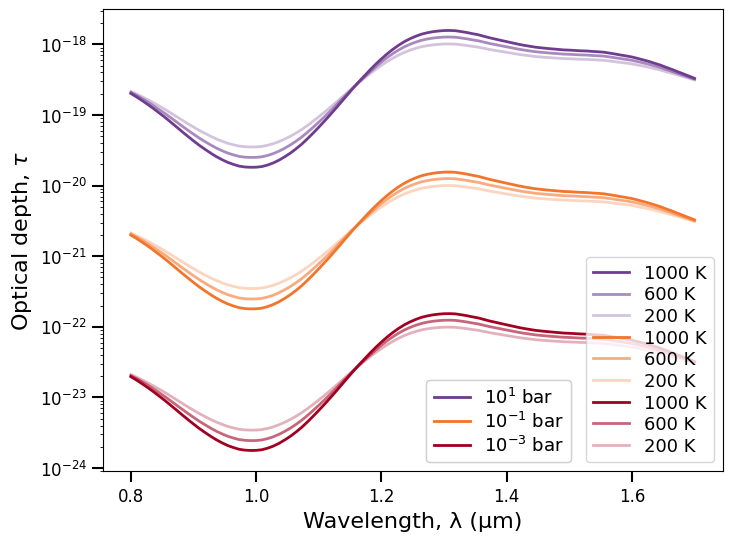

In [12]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

tau_list = [[tau_00_wavelength, tau_10_wavelength, tau_20_wavelength], 
            [tau_01_wavelength, tau_11_wavelength, tau_21_wavelength],
            [tau_02_wavelength, tau_12_wavelength, tau_22_wavelength]]

color_list = ['#A20021', '#F3752B', '#703C90']
alpha_list = [0.3, 0.6, 1]

t_handle_list, t_label_list = [], []
p_handle_list, p_label_list = [], []

for j, tau_p in enumerate(tau_list):
    for i, tau_t in enumerate(tau_p):
        plot1, = ax.semilogy(wavelength, tau_t, color=color_list[j], alpha=alpha_list[i], lw=2)
        t_handle_list.append(plot1)
        t_label_list.append(str(temperature[i]) + ' K')
    p_handle_list.append(plot1)
    p_label_list.append('10$^{' + str(int(np.log10(pressure[j]))) + '}$ bar')

plot2, = ax.semilogy(wavelength, tau_cloud_wavelength, color='gray', ls='--', lw=2)

ax.set_ylabel(r'Optical depth, $\tau$', size=16)
ax.set_xlabel('Wavelength, λ (µm)', size=16)

leg1 = ax.legend(t_handle_list[::-1], t_label_list[::-1], loc='lower right', fontsize=13, labelspacing=0.2)
leg2 = ax.legend(p_handle_list[::-1], p_label_list[::-1], loc='lower right', fontsize=13, bbox_to_anchor=(0.77, 0), labelspacing=0.2)

ax.add_artist(leg1)
ax.add_artist(leg2)

tkw = dict(size=8, width=1.5, labelsize=12)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)

plt.show()

In [13]:
R0 = (1 * u.R_jup).cgs.value  # reference radius [Jupiter radii]
Pmin = 1e-6  # mininum pressure [bar]
P0 = 1e1  # reference pressure [bar]
T0 = 1000  # reference temperature [K]
X_H2O = 1e-3  # abundance fraction
m_H20 = 18.0  # water mass [g / mol]
g = 980  # surface gravity [cm / s^2]

n_levels = 200  # number of atmospheric layers + 1

# convert the arguments from astropy `Quantity`s to
# floats in cgs units:
#args = (R_0, P_0, T_0, mmw, g)
#cgs_args = (arg.cgs.value for arg in args)  # this is not working, don't know why

# compute the planetary radius as a function of wavelength:
Rp = novais_2024.transmission_radius_nonisobaric(
     tau_interpolator_grid, P_cloudtop, 
     R0, P0, T0, X_H2O, X_H2O, g,
     Pmin, n_levels, wavelength
)

# convert to transit depth:
Rstar = (1 * u.R_sun).cgs.value

transit_depth_pct = 100.0 * (Rp / Rstar) ** 2
transit_depth_ppm = 1e6 * (Rp / Rstar) ** 2

#print(transit_depth_pct)

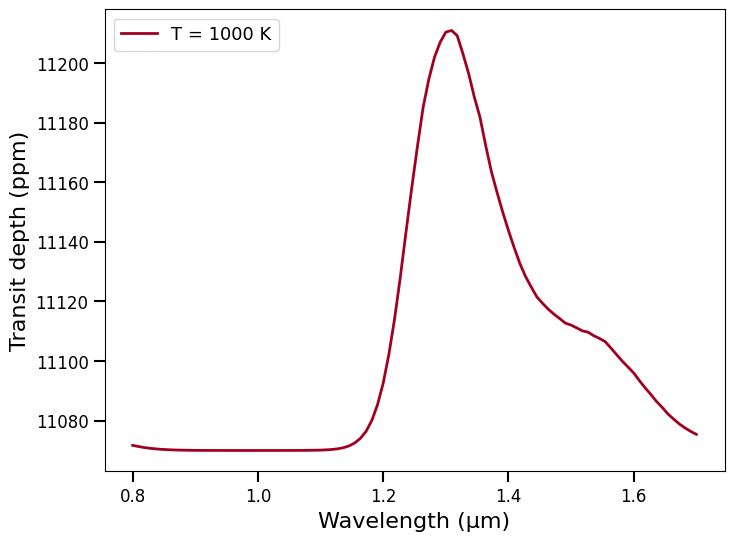

In [19]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

color_list = ['#A20021', '#F3752B', '#703C90']
alpha_list = [0.3, 0.6, 1]

plot1, = ax.plot(wavelength, transit_depth_ppm, color=color_list[0], lw=2)
str1 = 'T = ' + str(T0) + ' K'

ax.set_ylabel('Transit depth (ppm)', size=16)
ax.set_xlabel('Wavelength (µm)', size=16)

ax.legend([plot1], [str1], loc='upper left', fontsize=13)

tkw = dict(size=8, width=1.5, labelsize=12)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)

plt.show()